In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
import vqe_functions as vqe
import qcnn_functions as qcnn


In [2]:
N = 4
J = 1
l_steps = 10
shift_invariance = 0

lams = np.linspace(0,2*J,l_steps)

step_size = 0.03
epochs = 250
shift_invariance = 0

In [3]:
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)

In [4]:
@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)

@qml.qnode(dev_vqe_mixed)
def qcnn_circuit(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    qcnn.qcnn(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
    
    return qml.probs(wires = N - 1)


***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 500 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)──RX(0.00)─╭C────────||──RY(0.00)─┤ ╭<𝓗>
1: ──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)──RX(0.00)─╰X─╭C─────||──RY(0.00)─┤ ├<𝓗>
2: ──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)──RX(0.00)────╰X─╭C──||──RY(0.00)─┤ ├<𝓗>
3: ──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)──RX(0.00)───────╰X──||──RY(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/4 [00:00<?, ?it/s]

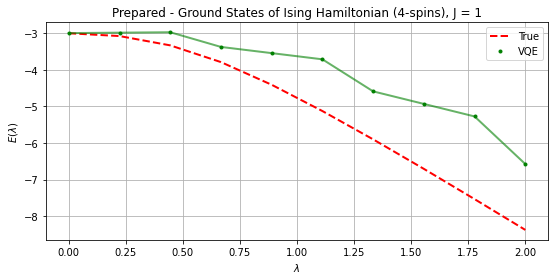

  0%|          | 0/500 [00:00<?, ?it/s]

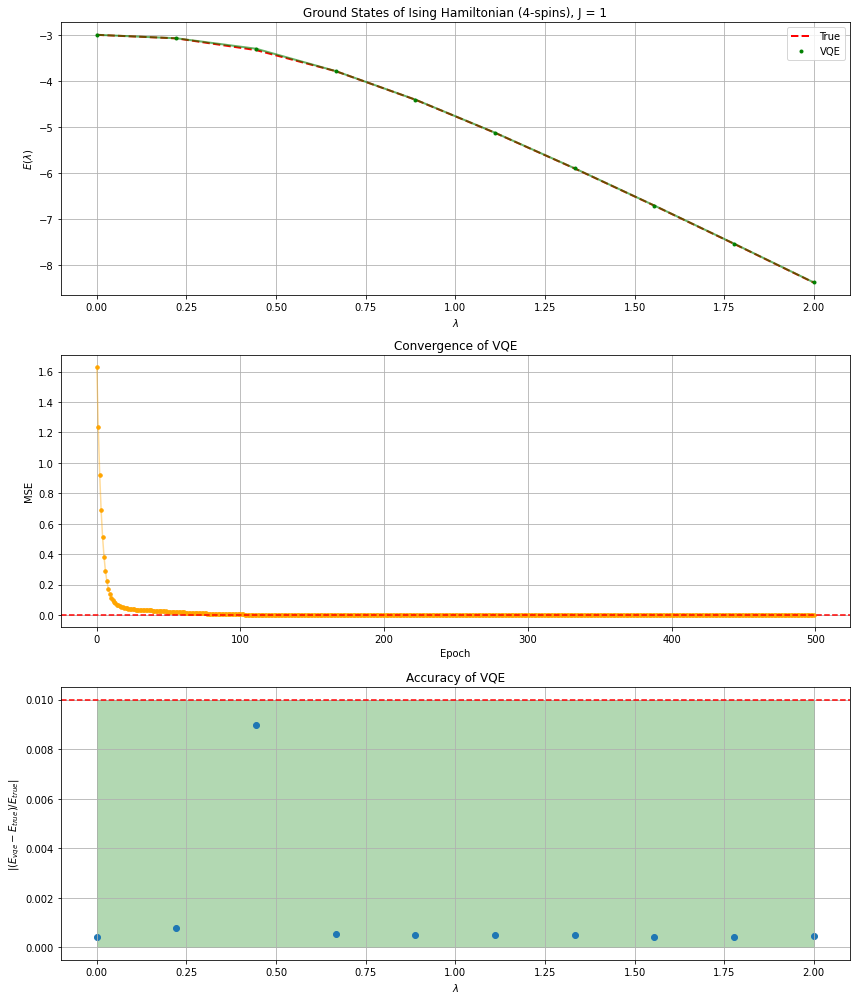

In [5]:
vqe_e, errs, thetas, ys = vqe.mptrain(0.03, 500, N, J, l_steps, vqe_cost_fn_mixed, optimizer = 'Adam',
                                      shift_invariance = shift_invariance, p_noise = 0, p_noise_ent = 0,
                                      circuit = True, plots = True, prepare_states = True, preplots = True,
                                      prep_step_size = 0.05, cutoff_value = .0005)

In [6]:
def optuna_find_hparameters(ntrials = 20, nepochs = 10):
    '''
    Function for Optuna hyperparameter tuning
    '''
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction='minimize')
    
    def optuna_train(trial):
        '''
        Main function for optuna.
        '''
        epochs = nepochs
        cfg = {
          'step_size': trial.suggest_loguniform('step_size',1e-4,1e0),
          'random_shift': trial.suggest_loguniform('random_shift',1e-8,1e1)
        }
        
        loss_history, accuracy_history, params = qcnn.train(nepochs, cfg['step_size'], cfg['random_shift'], 0, N, 0, 0, 0, 0,
                                                    qcnn_circuit, thetas, ys, plot = True)

        return loss_history[-1]
    
    study.optimize(optuna_train, n_trials=ntrials)
    
    return study

[I 2022-06-20 13:00:40,712] A new study created in memory with name: no-name-c4b30ac9-afdd-43ba-a2e0-10436c70f7f2


***Parameters:***

a factor   = 0.0005009926011297713 ('a' coefficient of the optimizer)
r_shift    = 0.005490821449911524 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:02:14,482] Trial 0 finished with value: 6.699729240913743 and parameters: {'step_size': 0.0005009926011297713, 'random_shift': 0.005490821449911524}. Best is trial 0 with value: 6.699729240913743.


***Parameters:***

a factor   = 0.0021872233605497926 ('a' coefficient of the optimizer)
r_shift    = 3.365662821081795e-05 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:03:46,636] Trial 1 finished with value: 6.32289967949687 and parameters: {'step_size': 0.0021872233605497926, 'random_shift': 3.365662821081795e-05}. Best is trial 1 with value: 6.32289967949687.


***Parameters:***

a factor   = 0.009613176578041567 ('a' coefficient of the optimizer)
r_shift    = 2.97120208332218e-05 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:05:18,082] Trial 2 finished with value: 4.6002398026265245 and parameters: {'step_size': 0.009613176578041567, 'random_shift': 2.97120208332218e-05}. Best is trial 2 with value: 4.6002398026265245.


***Parameters:***

a factor   = 0.02055951573597724 ('a' coefficient of the optimizer)
r_shift    = 0.15605464378147374 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:06:49,477] Trial 3 finished with value: 4.668750474160602 and parameters: {'step_size': 0.02055951573597724, 'random_shift': 0.15605464378147374}. Best is trial 2 with value: 4.6002398026265245.


***Parameters:***

a factor   = 0.5376013257541504 ('a' coefficient of the optimizer)
r_shift    = 1.408294079763956e-07 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:08:21,376] Trial 4 finished with value: 3.238514132550732 and parameters: {'step_size': 0.5376013257541504, 'random_shift': 1.408294079763956e-07}. Best is trial 4 with value: 3.238514132550732.


***Parameters:***

a factor   = 0.2936569997769736 ('a' coefficient of the optimizer)
r_shift    = 0.004723492993798146 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:09:53,085] Trial 5 finished with value: 3.054489348730668 and parameters: {'step_size': 0.2936569997769736, 'random_shift': 0.004723492993798146}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.00013810513200063974 ('a' coefficient of the optimizer)
r_shift    = 4.866976018490392e-07 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:11:25,428] Trial 6 finished with value: 8.535215362992107 and parameters: {'step_size': 0.00013810513200063974, 'random_shift': 4.866976018490392e-07}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.12580934510164604 ('a' coefficient of the optimizer)
r_shift    = 1.112895496440944e-05 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:12:57,637] Trial 7 finished with value: 3.533719770882397 and parameters: {'step_size': 0.12580934510164604, 'random_shift': 1.112895496440944e-05}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.003958319518579166 ('a' coefficient of the optimizer)
r_shift    = 3.945354094302722e-05 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:14:30,032] Trial 8 finished with value: 7.413367120270693 and parameters: {'step_size': 0.003958319518579166, 'random_shift': 3.945354094302722e-05}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.02062591628526913 ('a' coefficient of the optimizer)
r_shift    = 0.012479403709657668 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:16:02,496] Trial 9 finished with value: 4.828305794692302 and parameters: {'step_size': 0.02062591628526913, 'random_shift': 0.012479403709657668}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.47676918303817456 ('a' coefficient of the optimizer)
r_shift    = 4.658207622983616 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

/home/saverio/Desktop/CERN/code/phase-estimation/qcnn_functions.py:284: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))
[I 2022-06-20 13:17:35,182] Trial 10 finished with value: 6.02498296588803 and parameters: {'step_size': 0.47676918303817456, 'random_shift': 4.658207622983616}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.8593991639274002 ('a' coefficient of the optimizer)
r_shift    = 1.720419348355684e-08 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:19:07,857] Trial 11 finished with value: 3.2183999229829046 and parameters: {'step_size': 0.8593991639274002, 'random_shift': 1.720419348355684e-08}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.09560303426494801 ('a' coefficient of the optimizer)
r_shift    = 1.9575785366017803e-08 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:20:40,449] Trial 12 finished with value: 3.635535739962434 and parameters: {'step_size': 0.09560303426494801, 'random_shift': 1.9575785366017803e-08}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.8933941253135463 ('a' coefficient of the optimizer)
r_shift    = 0.0007609659697116978 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:22:13,045] Trial 13 finished with value: 3.2366657233800544 and parameters: {'step_size': 0.8933941253135463, 'random_shift': 0.0007609659697116978}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.12571166806895842 ('a' coefficient of the optimizer)
r_shift    = 0.21808348889616988 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:23:45,487] Trial 14 finished with value: 3.838384177403225 and parameters: {'step_size': 0.12571166806895842, 'random_shift': 0.21808348889616988}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.21742813851710563 ('a' coefficient of the optimizer)
r_shift    = 1.233090146465278e-06 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:25:17,754] Trial 15 finished with value: 3.575592269910857 and parameters: {'step_size': 0.21742813851710563, 'random_shift': 1.233090146465278e-06}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.0382821056243202 ('a' coefficient of the optimizer)
r_shift    = 0.0007785388278099454 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:26:50,179] Trial 16 finished with value: 4.399827504878163 and parameters: {'step_size': 0.0382821056243202, 'random_shift': 0.0007785388278099454}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.30874747475881187 ('a' coefficient of the optimizer)
r_shift    = 1.4322780916732894e-08 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:28:22,783] Trial 17 finished with value: 3.496644800213559 and parameters: {'step_size': 0.30874747475881187, 'random_shift': 1.4322780916732894e-08}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.9925186384003128 ('a' coefficient of the optimizer)
r_shift    = 0.039770319596855404 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:29:55,136] Trial 18 finished with value: 3.0905635740185553 and parameters: {'step_size': 0.9925186384003128, 'random_shift': 0.039770319596855404}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.047350455737592896 ('a' coefficient of the optimizer)
r_shift    = 0.08779584647473103 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:31:27,866] Trial 19 finished with value: 3.7493236961458836 and parameters: {'step_size': 0.047350455737592896, 'random_shift': 0.08779584647473103}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.24107066784675343 ('a' coefficient of the optimizer)
r_shift    = 2.593641930136015 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:33:00,294] Trial 20 finished with value: 6.978471884054986 and parameters: {'step_size': 0.24107066784675343, 'random_shift': 2.593641930136015}. Best is trial 5 with value: 3.054489348730668.


***Parameters:***

a factor   = 0.9479616171874354 ('a' coefficient of the optimizer)
r_shift    = 0.006652639511903203 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:34:32,901] Trial 21 finished with value: 3.0373068162315926 and parameters: {'step_size': 0.9479616171874354, 'random_shift': 0.006652639511903203}. Best is trial 21 with value: 3.0373068162315926.


***Parameters:***

a factor   = 0.8362615459414032 ('a' coefficient of the optimizer)
r_shift    = 0.006677346947761164 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:36:05,286] Trial 22 finished with value: 3.2912483299633046 and parameters: {'step_size': 0.8362615459414032, 'random_shift': 0.006677346947761164}. Best is trial 21 with value: 3.0373068162315926.


***Parameters:***

a factor   = 0.2531938975556904 ('a' coefficient of the optimizer)
r_shift    = 0.03542137441856524 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:37:37,818] Trial 23 finished with value: 3.2135020366279416 and parameters: {'step_size': 0.2531938975556904, 'random_shift': 0.03542137441856524}. Best is trial 21 with value: 3.0373068162315926.


***Parameters:***

a factor   = 0.07186205891394051 ('a' coefficient of the optimizer)
r_shift    = 0.00024457265913179626 (c coefficient of the optimizer)
epochs     = 500 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-06-20 13:39:09,700] Trial 24 finished with value: 3.251793371260116 and parameters: {'step_size': 0.07186205891394051, 'random_shift': 0.00024457265913179626}. Best is trial 21 with value: 3.0373068162315926.


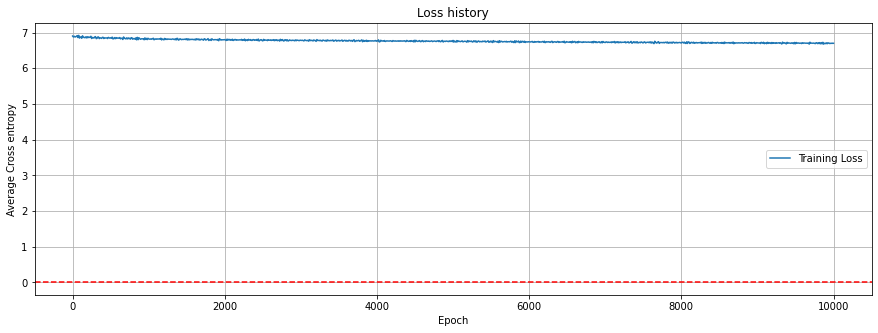

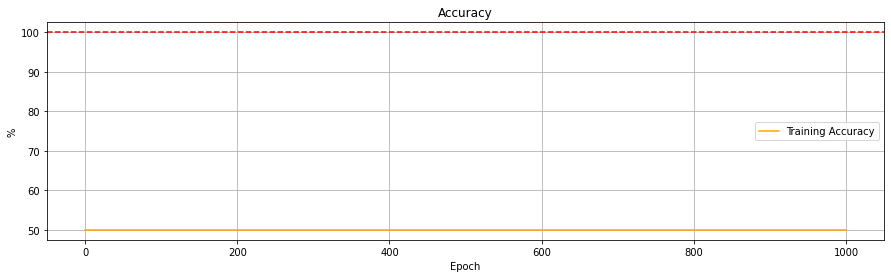

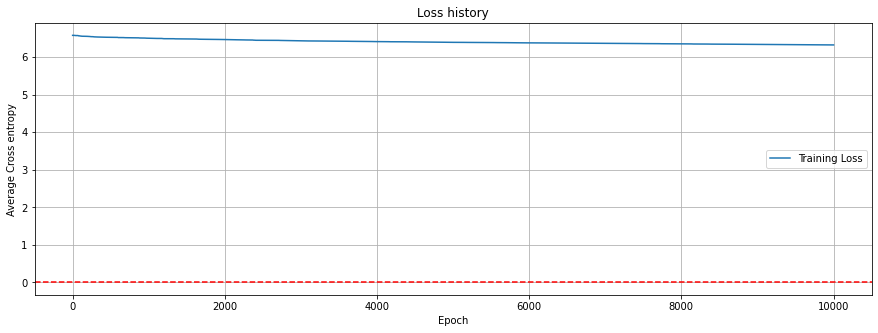

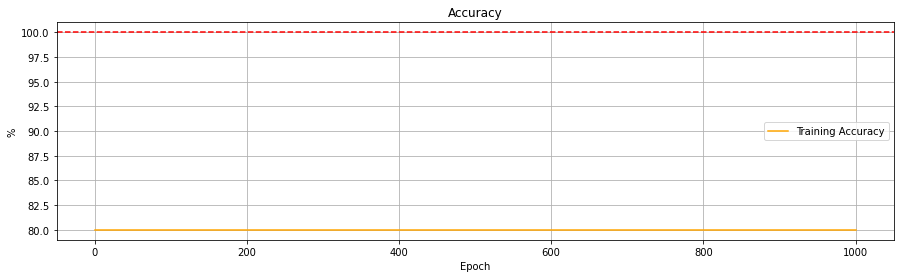

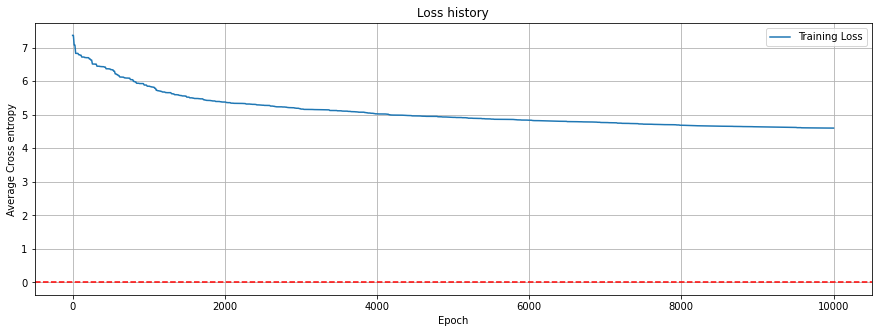

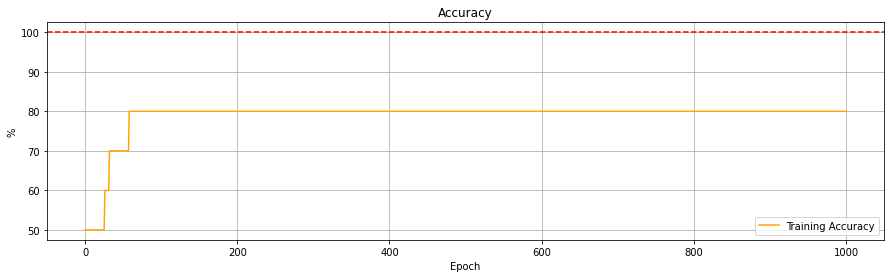

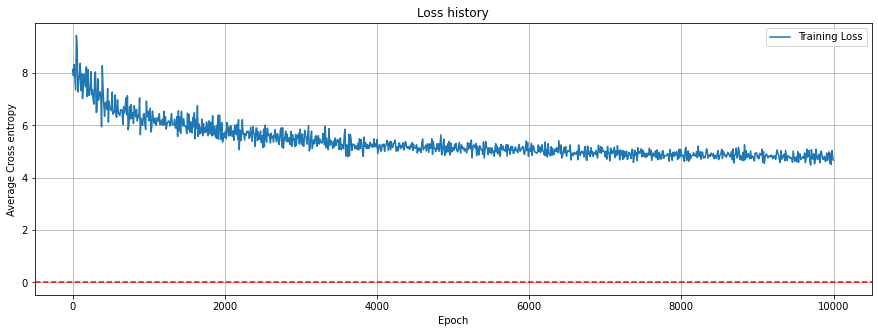

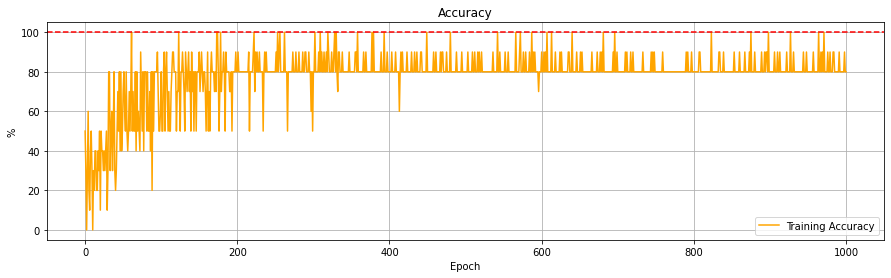

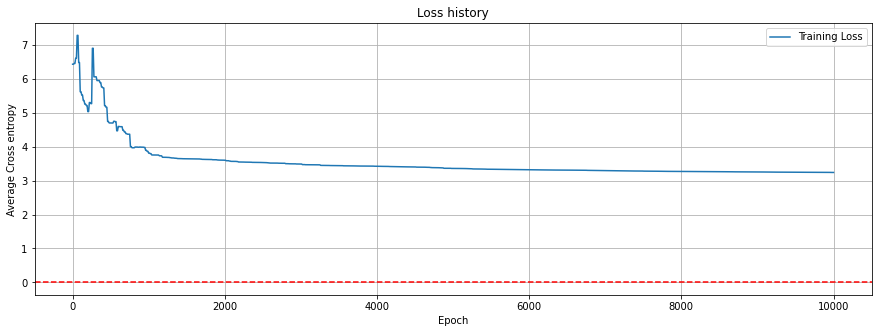

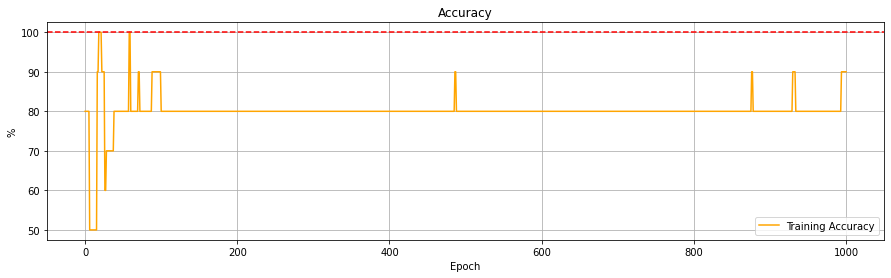

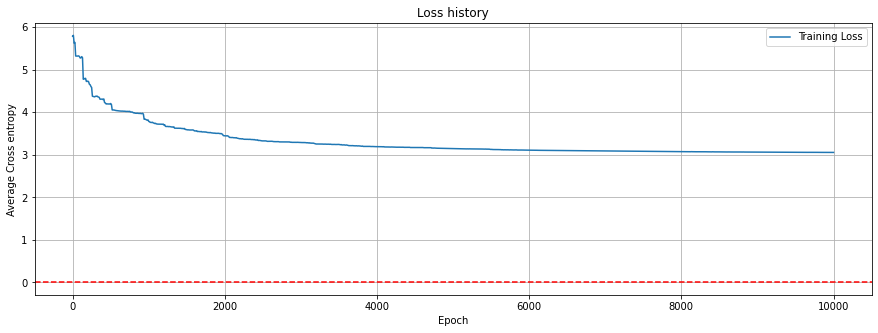

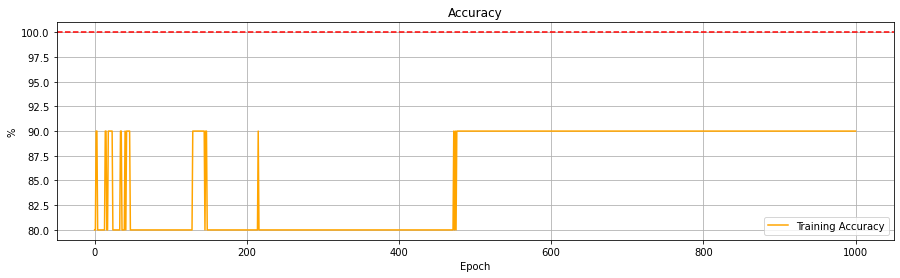

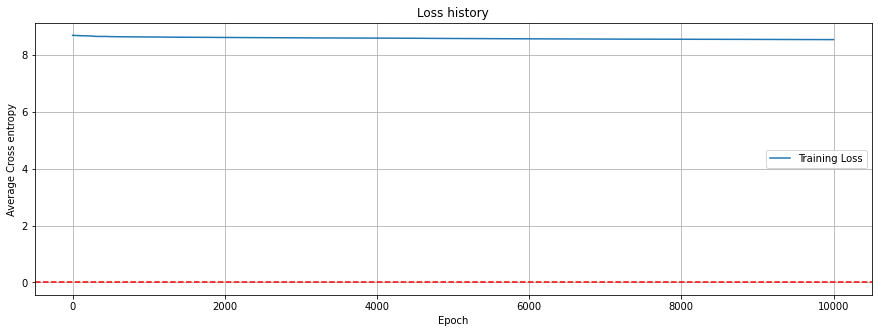

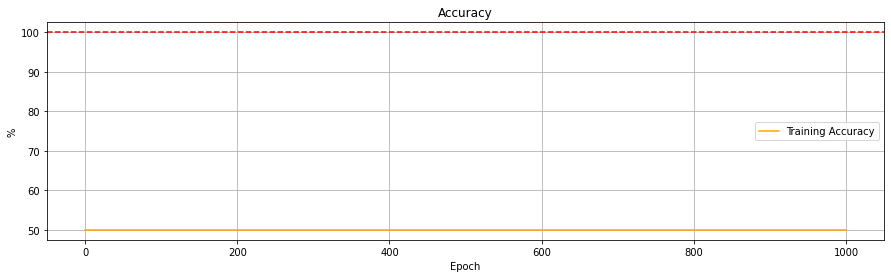

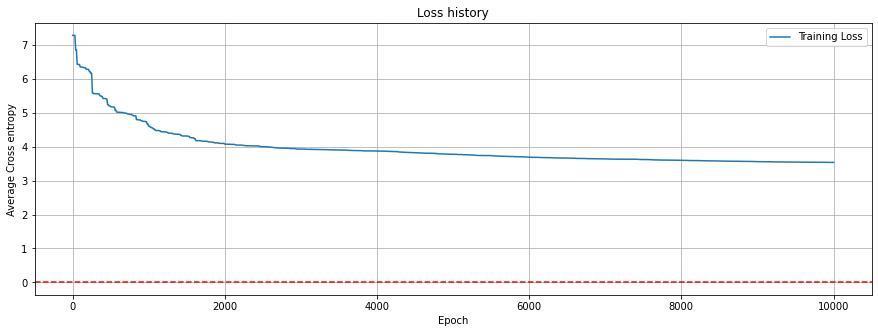

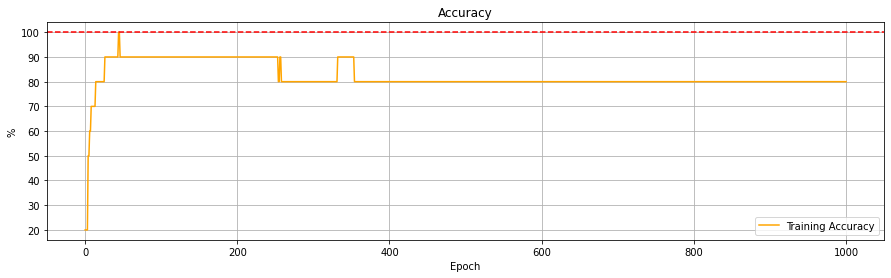

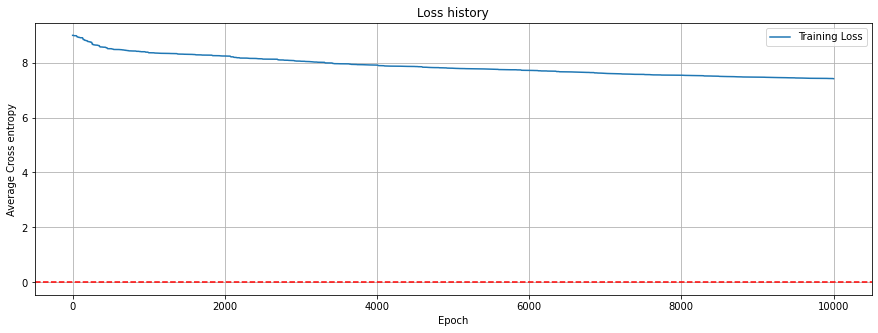

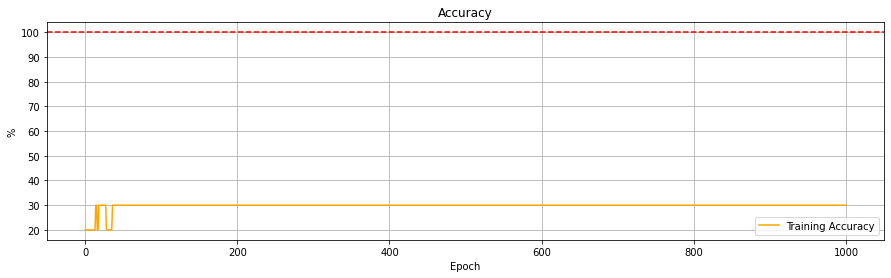

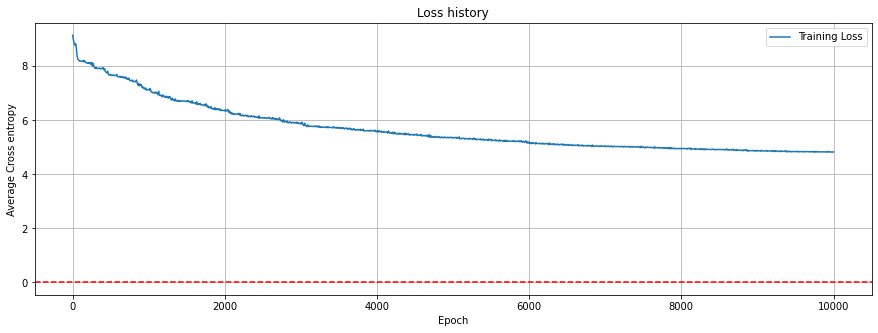

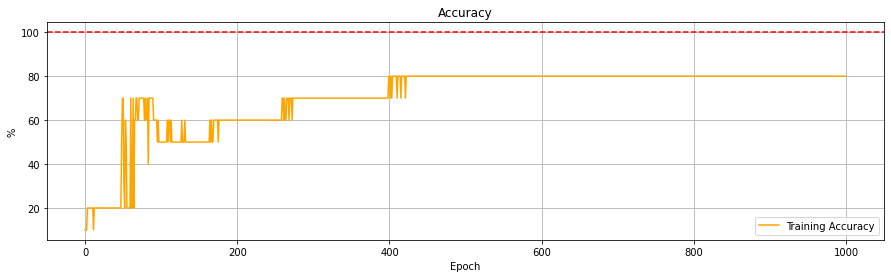

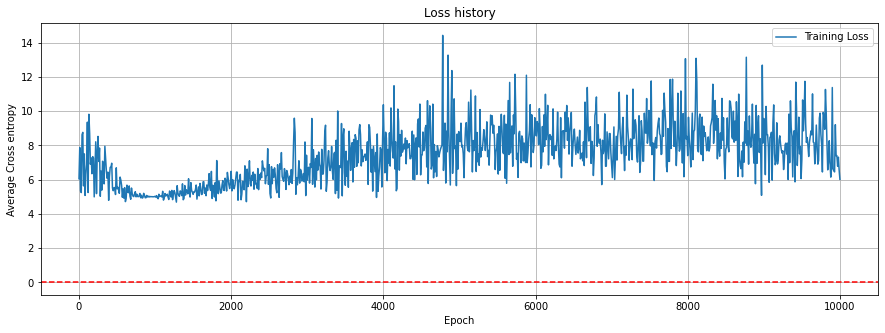

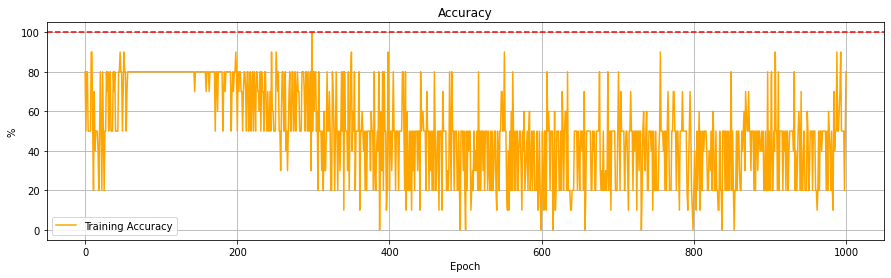

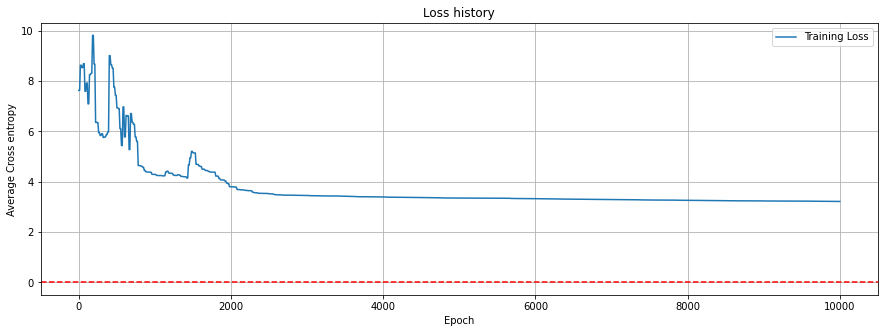

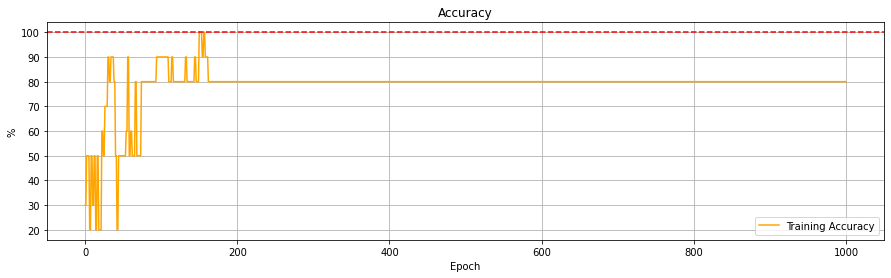

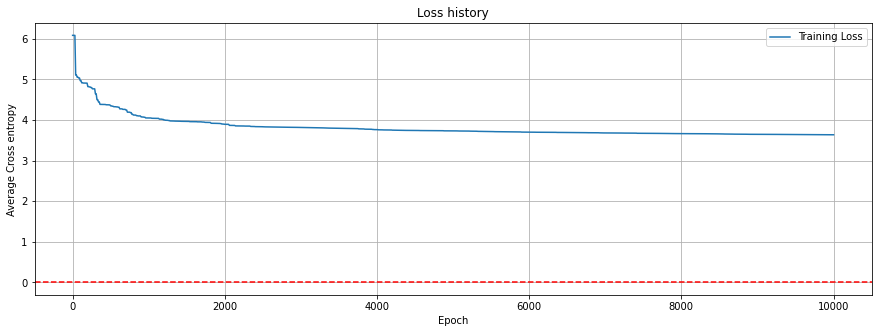

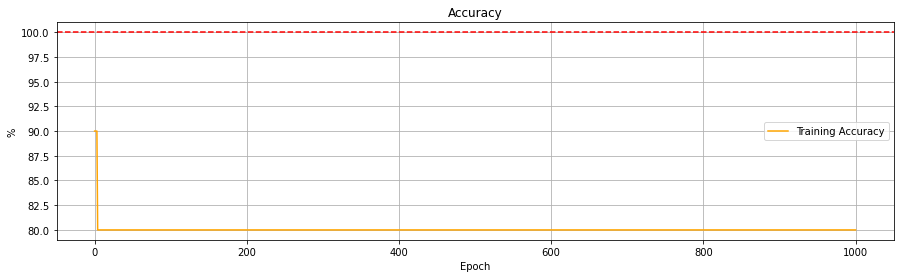

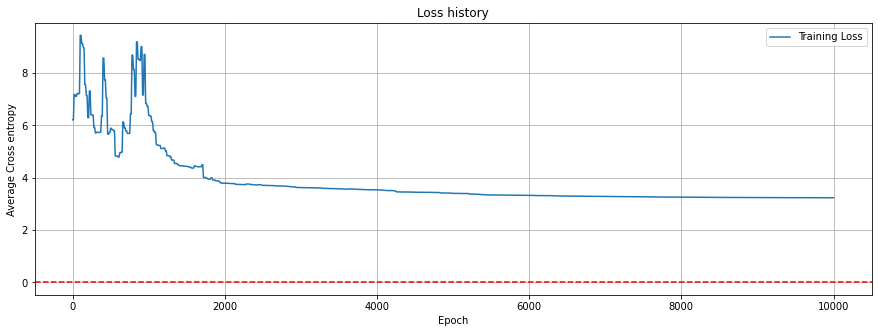

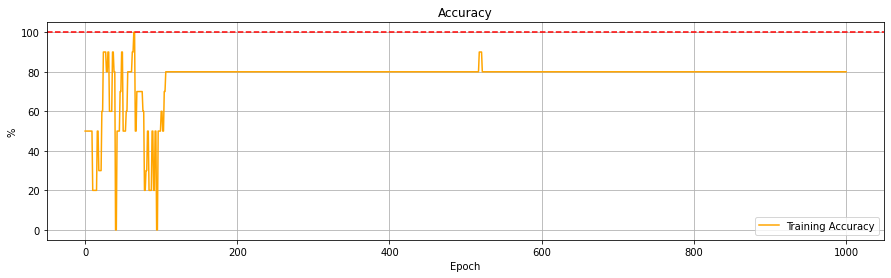

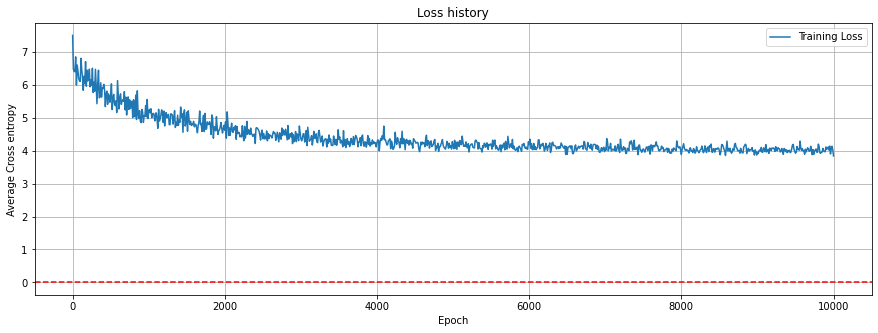

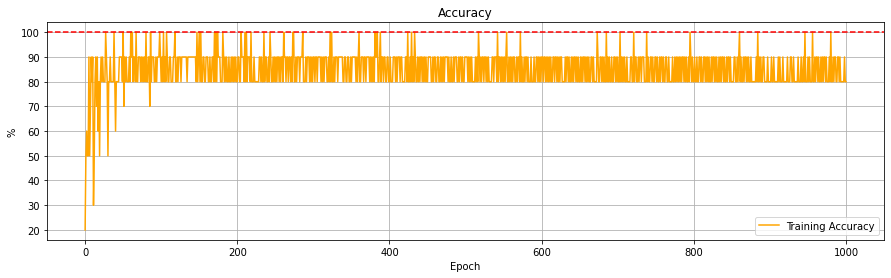

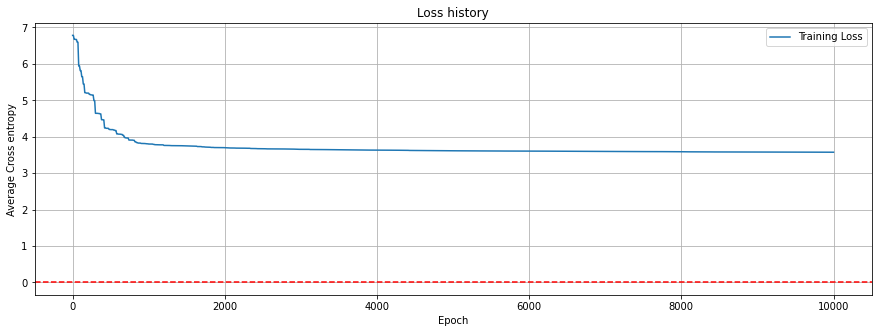

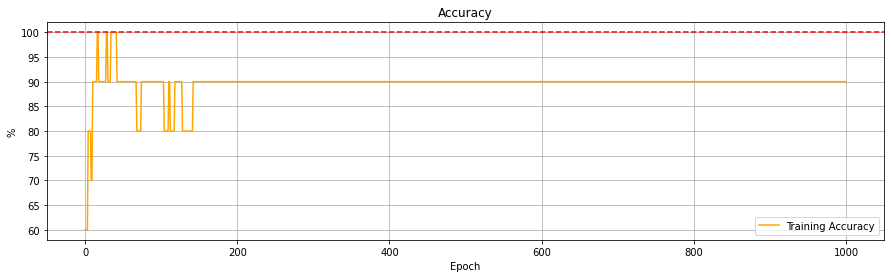

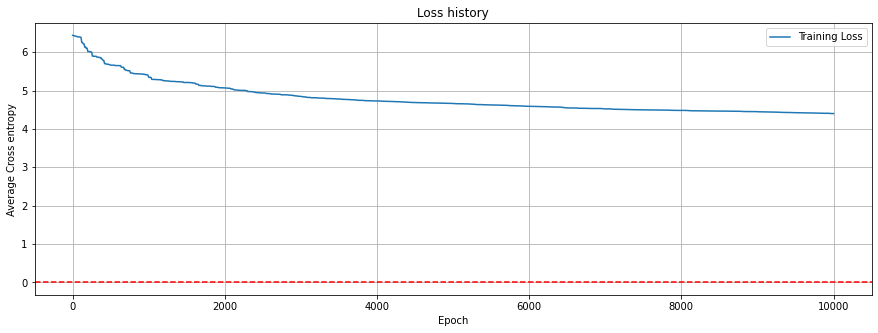

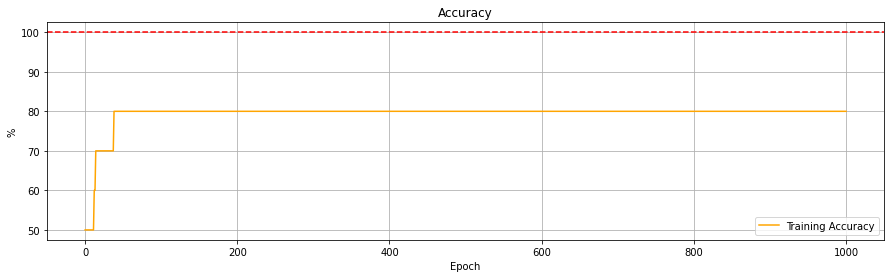

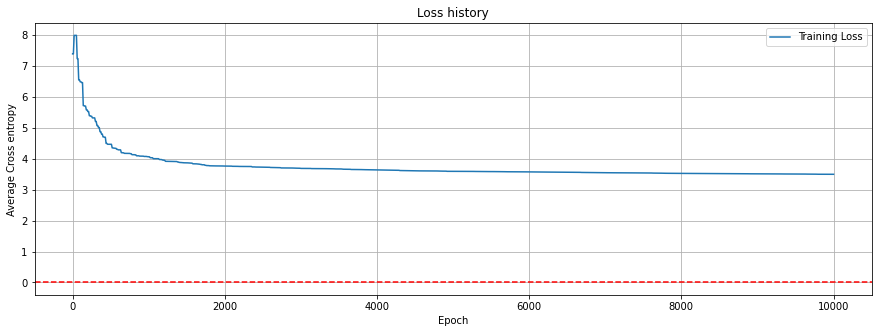

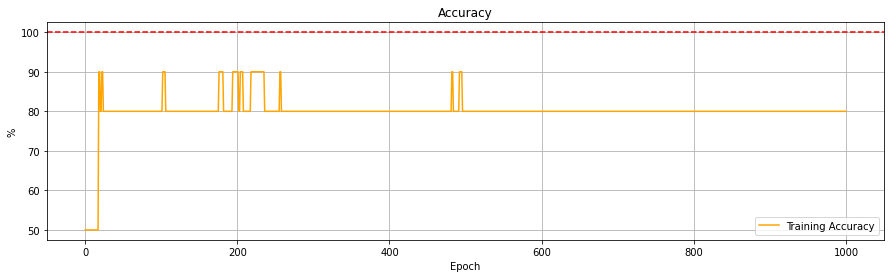

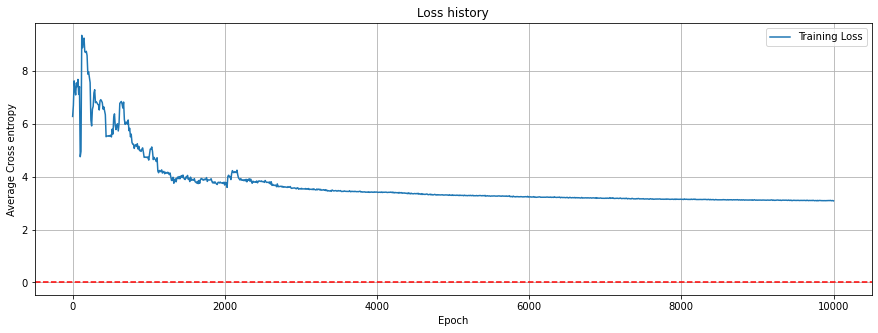

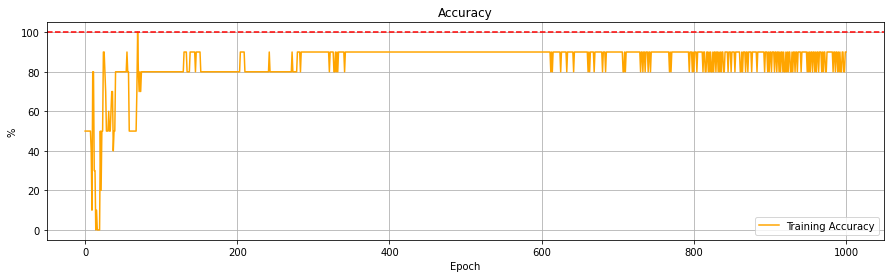

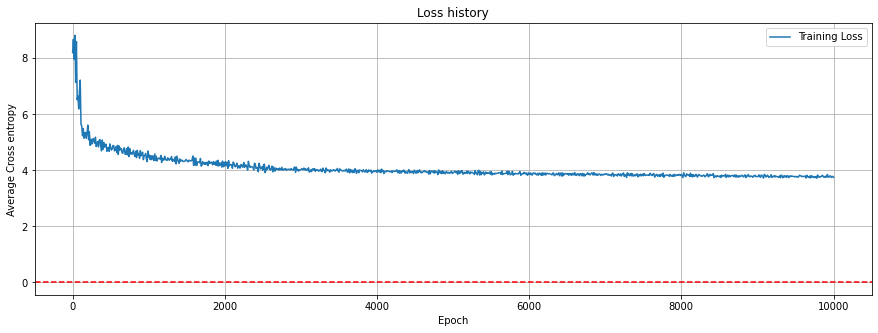

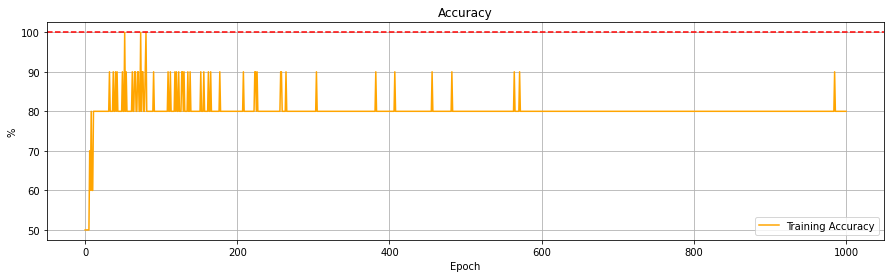

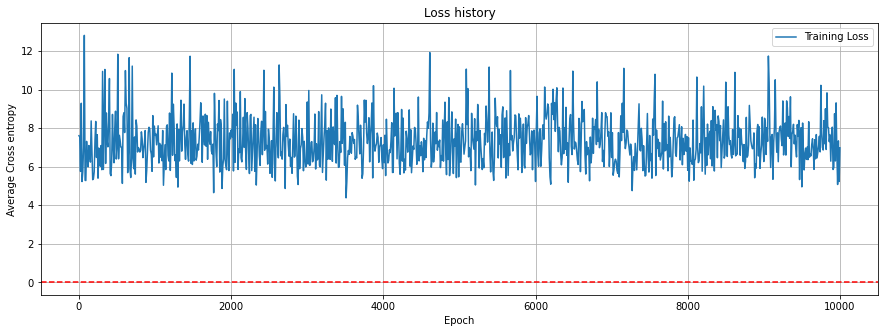

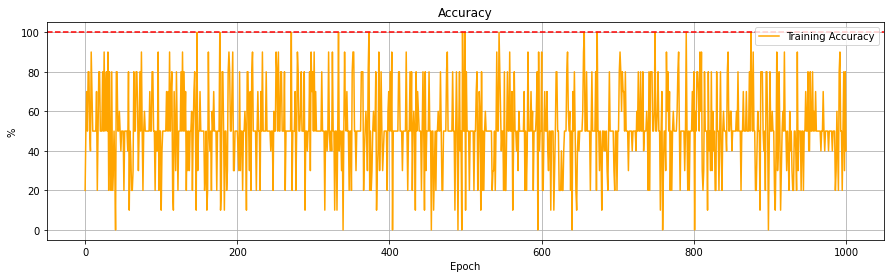

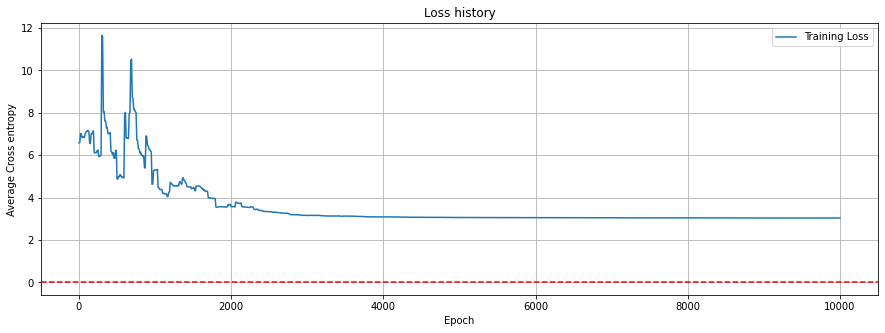

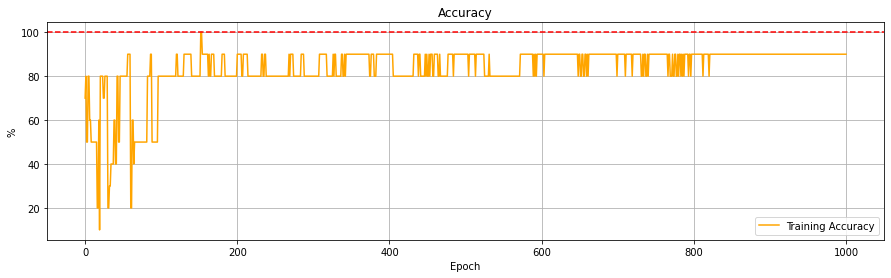

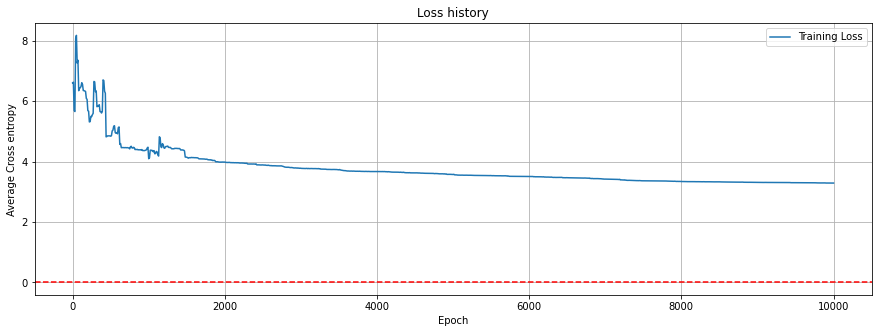

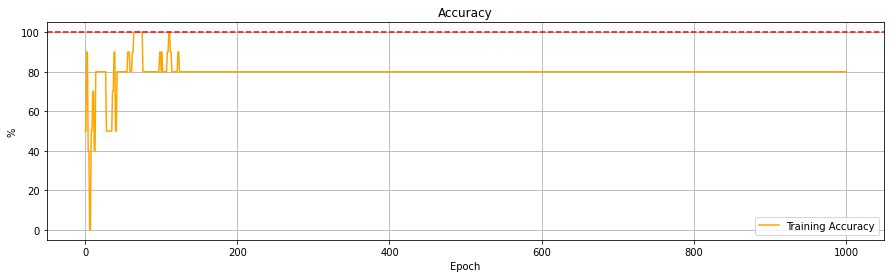

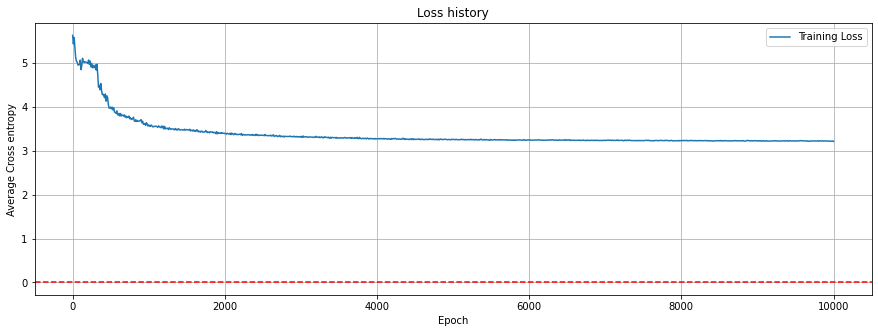

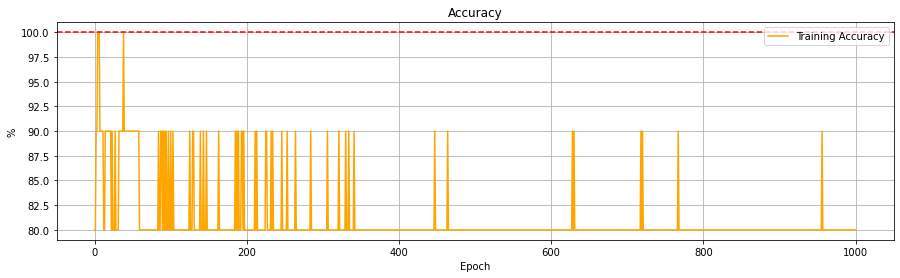

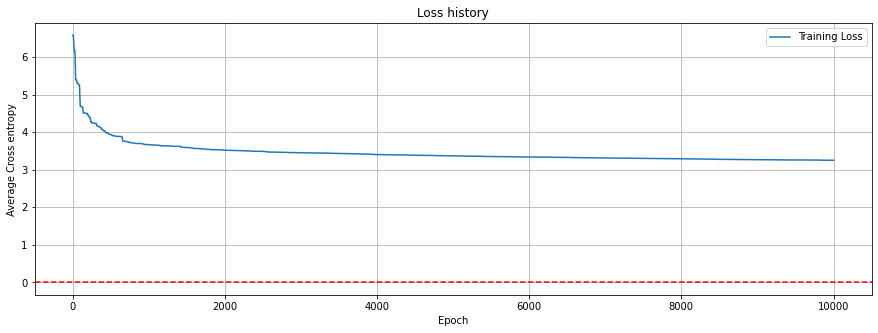

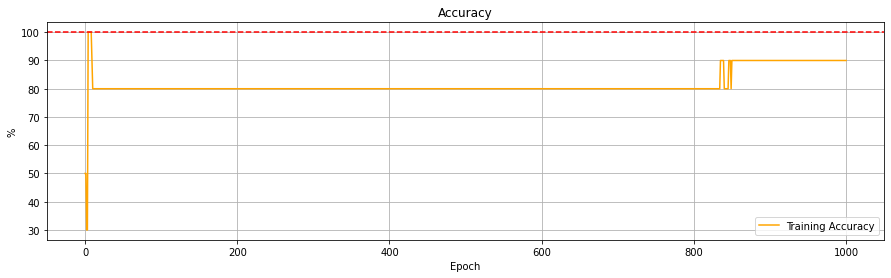

In [8]:
study = optuna_find_hparameters(ntrials = 25, nepochs = 500)

***Parameters:***

a factor   = 0.5 ('a' coefficient of the optimizer)
r_shift    = 0.05 (c coefficient of the optimizer)
epochs     = 5000 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/5000 [00:00<?, ?it/s]

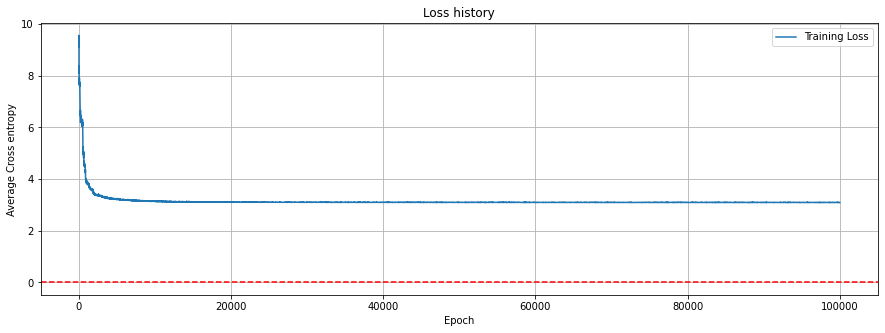

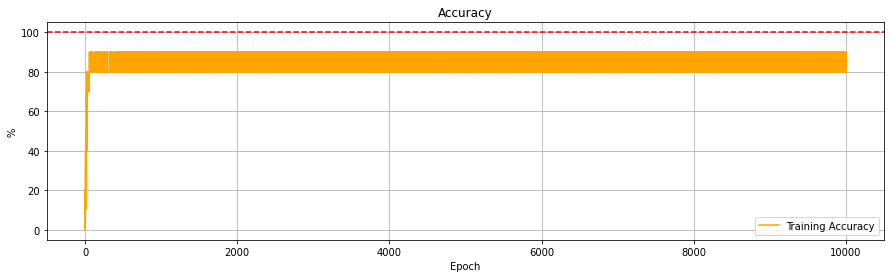

In [36]:
loss_history, accuracy_history, params = qcnn.train(5000, .5, .05, 0, N, 0, 0, 0, 0,
                                                    qcnn_circuit, thetas, ys, plot = True)

In [26]:
data = []
for x, y in zip(thetas,ys):
    data.append((x, y))

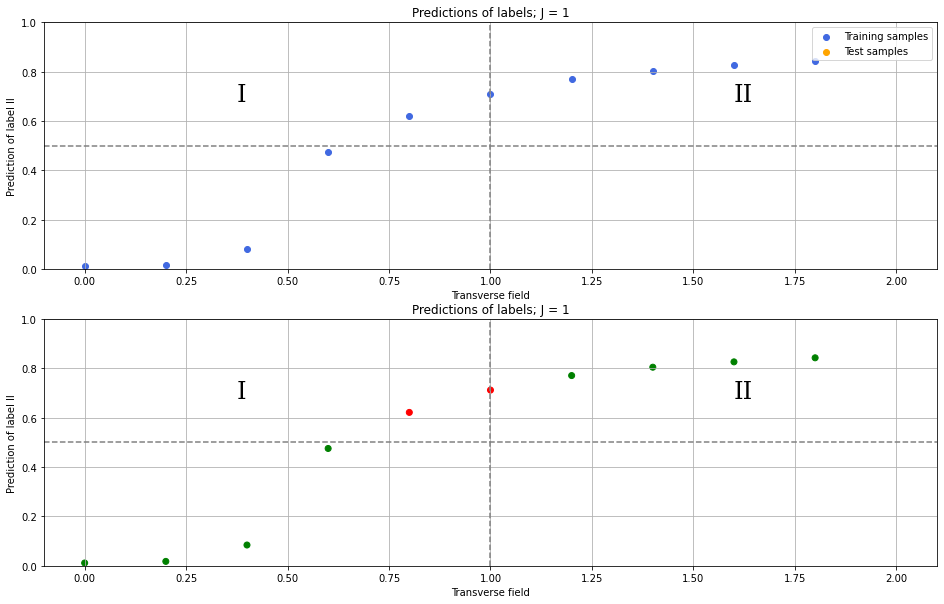

In [32]:
qcnn.plot_results_classification(data, np.arange(len(data)), params, 0, N, qcnn_circuit)